# Set for jupyter notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Env

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import os
import random
from PIL import Image

In [3]:
from modules.dataset import get_loader
from modules.utils import imsshow, imgshow
from modules.network import UNet
from modules.loss import MyBinaryCrossEntropy
from modules.solver import Lab2Solver

In [4]:
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data process

In [5]:
BG = [0]
RV = [85]
MYO = [170]
LV = [255]

train_loader = get_loader(image_root_path='./ACDC-2D-All/train/',palette=[RV,MYO,LV], batch_size=32, mode='train')
val_loader = get_loader(image_root_path='./ACDC-2D-All/val/', palette=[RV,MYO,LV], batch_size=32, mode='val')
test_loader = get_loader(image_root_path='./ACDC-2D-All/test/',palette=[RV,MYO,LV], batch_size=32, mode='test')

image count in train path :1394
image count in val path :200
image count in test path :204


torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])


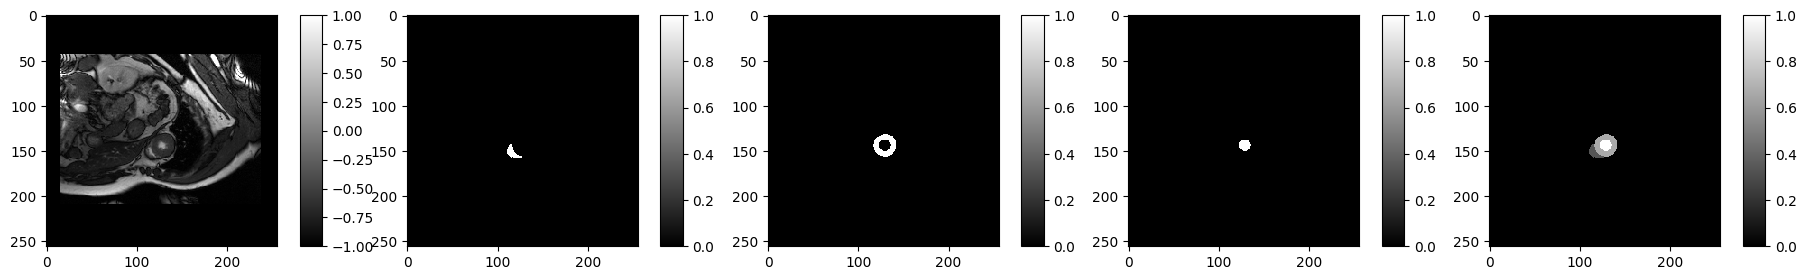

Number of 0.0 in the array: 64920
Number of 0.3333333432674408 in the array: 120
Number of 0.6666666865348816 in the array: 365
Number of 1.0 in the array: 131


In [6]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)

idx = 10
all_gt = (seg_gt[idx,0, :, :] * 85 + seg_gt[idx,1, :, :] * 170 + seg_gt[idx,2, :, :] * 255)/255
imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :],seg_gt[idx, 1, :, :],seg_gt[idx, 2, :, :], all_gt], is_colorbar=True, is_ticks=True)

# for testing
# imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :]], is_colorbar=True, is_ticks=True)

target = all_gt
unique, count = np.unique(target, return_counts=True)

# Print the results
for u, c in zip(unique, count):
    print("Number of {} in the array: {}".format(u, c))

torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])


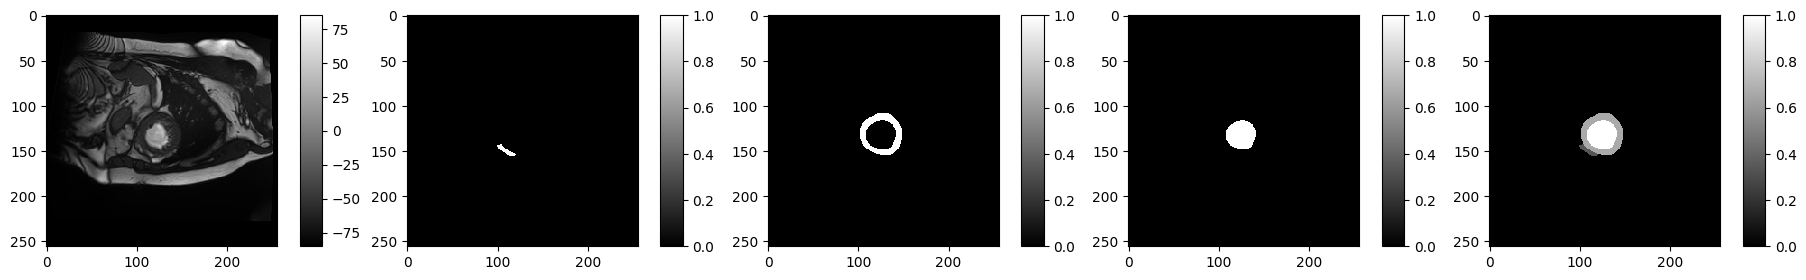

Number of 0.0 in the array: 63730
Number of 0.3333333432674408 in the array: 96
Number of 0.6666666865348816 in the array: 865
Number of 1.0 in the array: 845


In [32]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(val_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)

idx = 5
all_gt = (seg_gt[idx,0, :, :] * 85 + seg_gt[idx,1, :, :] * 170 + seg_gt[idx,2, :, :] * 255)/255
imsshow([image[idx, 0, :, :]* 85, seg_gt[idx, 0, :, :],seg_gt[idx, 1, :, :],seg_gt[idx, 2, :, :], all_gt], is_colorbar=True, is_ticks=True)

# for testing
# imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :]], is_colorbar=True, is_ticks=True)

target = all_gt
unique, count = np.unique(target, return_counts=True)

# Print the results
for u, c in zip(unique, count):
    print("Number of {} in the array: {}".format(u, c))

# Network and Solver

In [40]:
is_load = False
checkpoint = "checkpoint/04-06_19-24-59-v1.1-20+20+20epoch.pth"

net = UNet(n_channels=1, n_classes=3, C_base=32)
if is_load == True:
    net.load_state_dict(torch.load(checkpoint))

In [41]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

solver = Lab2Solver(
    model = net,
    optimizer = optimizer,
    criterion = MyBinaryCrossEntropy(),
    lr_scheduler=lr_scheduler,
    device="cuda:2"
)

# Train

In [42]:
solver.train(
    epochs=60,
    data_loader=train_loader,
    val_loader=val_loader
)

  0%|          | 0/1394 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

In [23]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)
print(seg_gt.dtype)

torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])
torch.float32


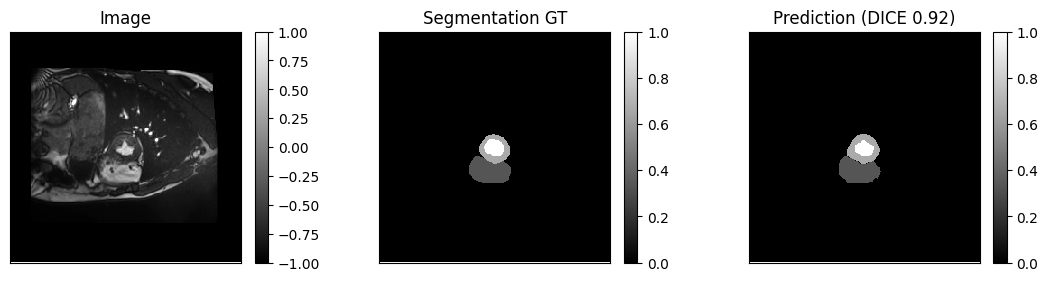

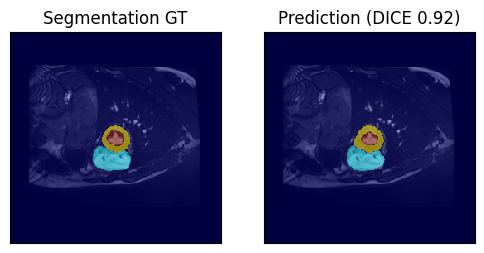

In [36]:
solver.visualize(test_loader, 11)

In [37]:
solver.validate(
    data_loader=test_loader
)

[Validation]:   0%|          | 0/204 [00:00<?, ?img/s]

============================== Measurements ==============================
[avg_Sensitivity] 0.8733922118621037
[avg_Specifity] 0.999394656418517
[avg_Precision] 0.9256103576319127
[avg_F1Score] 0.8985832734261097
[avg_JaccardSimilarity] 0.8159788263937595
[avg_DiceCoefficient] 0.8985837729238608
[avg_DiceCoefficient_square] 0.8075426619157077


# Save checkpoint

In [34]:
import time
timestamp = time.strftime("%m-%d_%H-%M-%S", time.localtime())

In [35]:
name = "v1.1-20+20+20epoch"
torch.save(net.state_dict(), f'./checkpoint/{timestamp}-{name}.pth')

# Test

In [37]:
is_load = True
checkpoint = "checkpoint/04-06_19-24-59-v1.1-20+20+20epoch.pth"

net = UNet(n_channels=1, n_classes=3, C_base=32)
if is_load == True:
    net.load_state_dict(torch.load(checkpoint))

In [38]:
import time
import imageio
import itertools
import numpy as np
from modules.evaluation import get_DC, get_DC_square

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
net = net.to(device)
net.eval()
dice = []
dice_square = []
for batch_num in range(7):
    print(batch_num, end=' ')
    img, gt = next(itertools.islice(test_loader, batch_num, None))
    img = img.to(device)
    gt = gt.to(device)
    result = net(img)
    pred_seg_probs = torch.sigmoid(result)
    DC_ALL = get_DC(pred_seg_probs, gt)
    DC_RV = get_DC(pred_seg_probs[:,0,:,:], gt[:,0,:,:])
    DC_MYO = get_DC(pred_seg_probs[:,1,:,:], gt[:,1,:,:])
    DC_LV = get_DC(pred_seg_probs[:,2,:,:], gt[:,2,:,:])
    dice.append([DC_ALL, DC_RV, DC_MYO, DC_LV])
#         output = (x_und[idx] * 255).astype('uint8')
#         imageio.mimsave(f'./gif_und/animation_{batch_num}_{idx}_{PSNR[-1]:.2f}.gif', output, fps=10)
print()
tag = ["All", "RV", "MYO", "LV"]
for i in range(4):
    dice_arr = np.array([dice[i]])
    print(f"[avg_{tag[i]}_DiceCoefficient]: {np.mean(dice_arr)}")
    print(f"[var_{tag[i]}_DiceCoefficient]: {np.var(dice_arr)}")

0 1 2 3 4 5 6 
[avg_All_DiceCoefficient]: 0.9283420539204176
[var_All_DiceCoefficient]: 0.0006279023654369494
[avg_RV_DiceCoefficient]: 0.9283420539204176
[var_RV_DiceCoefficient]: 0.0006279023654369494
[avg_MYO_DiceCoefficient]: 0.9283420539204176
[var_MYO_DiceCoefficient]: 0.0006279023654369494
[avg_LV_DiceCoefficient]: 0.9283420539204176
[var_LV_DiceCoefficient]: 0.0006279023654369494


In [39]:
tag = ["All", "RV", "MYO", "LV"]
for i in range(4):
    dice_arr = np.array([dice[i]])
    print(f"[avg_{tag[i]}_DiceCoefficient]: {np.mean(dice_arr)}")
    print(f"[var_{tag[i]}_DiceCoefficient]: {np.var(dice_arr)}")

[avg_All_DiceCoefficient]: 0.9283420539204176
[var_All_DiceCoefficient]: 0.0006279023654369494
[avg_RV_DiceCoefficient]: 0.9042730180689653
[var_RV_DiceCoefficient]: 0.0006530090599812062
[avg_MYO_DiceCoefficient]: 0.9175768362827311
[var_MYO_DiceCoefficient]: 0.00113203685740515
[avg_LV_DiceCoefficient]: 0.9126119736453524
[var_LV_DiceCoefficient]: 0.0005266117102490616
